# Задание

Разработать и обучить нейросеть для кластеризации входных данных

# Ход работы

## Использованные библиотеки

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

## Подготовка тренировочных данных

### Загрузка датасета MNIST

Датасет содержит в себе около 1000 рукописных цифр в формате матриц 28х28 с подписями

In [12]:
# Load MNIST data
train = torchvision.datasets.MNIST('data', train=True, download=True)
test = torchvision.datasets.MNIST('data', train=False, download=True)

### Преобразование данных датасета в нужный формат

In [13]:
# Преобразование в бинарный вид (0 или 1) с порогом 0.5
X_train = (train.data.reshape(-1, 784).float() / 255.0 > 0.5).float()
y_train = train.targets
X_test = (test.data.reshape(-1, 784).float() / 255.0 > 0.5).float()
y_test = test.targets

### Визуализация части датасета

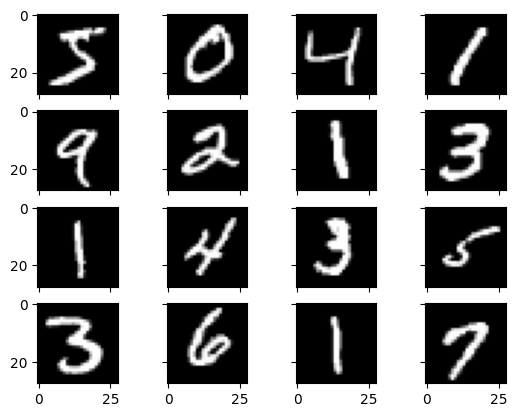

In [14]:
def visualize_image_tensor(ax, tensor):
    ax.imshow(tensor, cmap="gray")

def show_prototypes(prototypes, title="Prototypes"):
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    fig.suptitle(title)
    for i in range(10):
        row, col = i // 5, i % 5
        axes[row, col].imshow(prototypes[i].reshape(28, 28), cmap='gray')
        axes[row, col].set_title(f"Digit {i}")
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()

fig, ax = plt.subplots(4, 4, sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        visualize_image_tensor(ax[i][j], train.data[4 * i + j])
plt.show()

## Определение класса модели

Модель содержит в себе слой прототипов, слой для оценки расстояния хемминга, итеративный конкурентный слой

In [15]:
class HammingNetwork(nn.Module):
    def __init__(self, num_classes=10, input_size=784):
        super().__init__()
        # Слой прототипов (веса - бинарные прототипы каждого класса)
        self.prototypes = nn.Parameter(torch.zeros(num_classes, input_size), requires_grad=False)
        # Верхний слой для конкурентного взаимодействия
        self.competitive = nn.Linear(num_classes, num_classes, bias=False)
        
        with torch.no_grad():
            epsilon = 1.0 / num_classes
            self.competitive.weight.data = torch.full((num_classes, num_classes), -epsilon)
            for i in range(num_classes):
                self.competitive.weight.data[i,i] = 1.0
    
    def forward(self, x):
        # Первый слой - расстояние Хэмминга
        hamming_scores = x @ self.prototypes.t() + (1-x) @ (1-self.prototypes.t())
        
        # Итеративный конкурентный слой
        y = hamming_scores.clone()
        for _ in range(10):
            y = torch.clamp(self.competitive(y), min=0)
        
        return y
    
    def set_prototypes(self, prototypes):
        with torch.no_grad():
            self.prototypes.copy_(prototypes)

## Вычисление прототипов
Прототип - наиболее частые бинарные паттерны для каждого класса

Это бинарные векторы (из 0 и 1), представляющие "идеальный" образец каждого класса

Для MNIST (10 цифр) создаётся 10 прототипов размером 784 (28×28 пикселей)

Каждый прототип — это усреднённое представление всех изображений своего класса

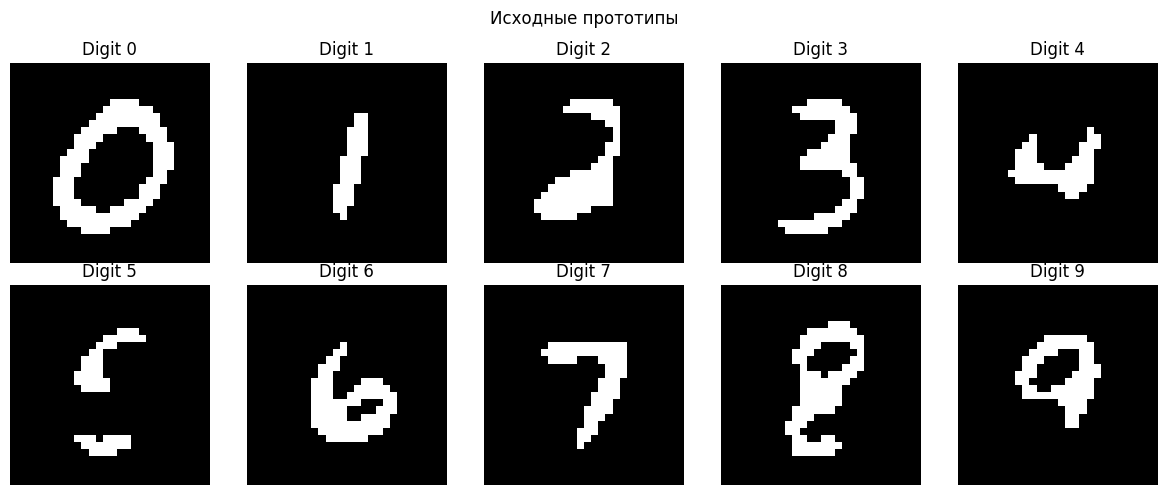

In [17]:
prototypes = torch.zeros(10, 784)
for digit in range(10):
    mask = (y_train == digit)
    class_images = X_train[mask]
    prototypes[digit] = (class_images.mean(0) > 0.5).float()

show_prototypes(prototypes, "Исходные прототипы")
model = HammingNetwork()
model.set_prototypes(prototypes)

optimizer = optim.SGD([model.prototypes], lr=0.01)
loss_fn = nn.CrossEntropyLoss()
loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=100)

## Проверка работоспособности модели

### Определение вспомогательных классов для доступа к изображениям

In [18]:
transform = transforms.Compose([
    transforms.PILToTensor()
])

class TestImage:
    def __init__(self, path):
        self.img = Image.open(path)
        self.data = transform(self.img)[0]

    @property
    def tensor(self):
        tensor = (self.data.reshape([1, 784]).float() / 255.0 > 0.5).float()
        return 1 - tensor

### Проверка модели на тестовых изображениях

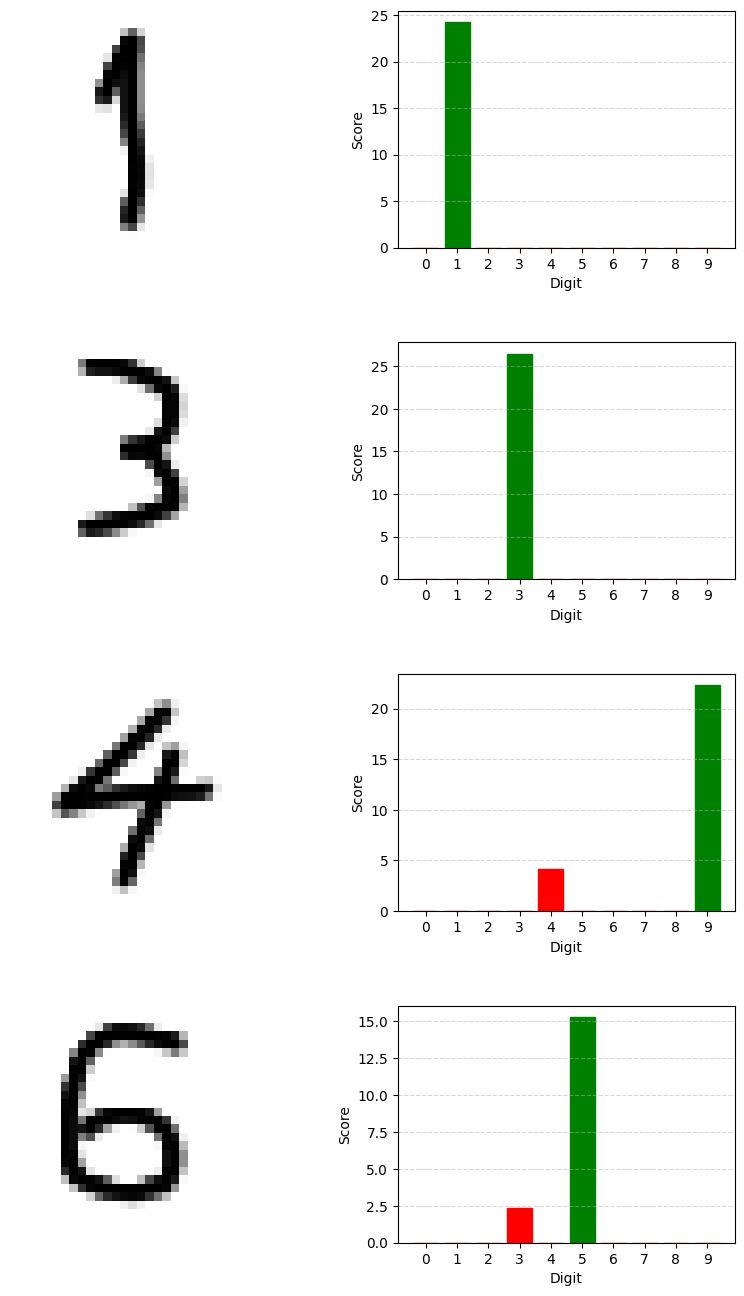

In [19]:
fig, axs = plt.subplots(4, 2, figsize=(10, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

paths = [
    "test-images/1.png",
    "test-images/3.png",
    "test-images/4.png",
    "test-images/6.png",
]

images = [TestImage(p) for p in paths]

for i, (image, ax_row) in enumerate(zip(images, axs)):
    visualize_image_tensor(ax_row[0], image.data)
    ax_row[0].axis('off')

    pred = model(image.tensor).detach().numpy()[0]
    digits = np.arange(10)
    bars = ax_row[1].bar(digits, pred)
    
    m = pred.argmax()
    for i, bar in enumerate(bars):
        bar.set_color('green' if i == m else 'red')
    
    ax_row[1].axhline(0, color='black', linewidth=0.5)
    ax_row[1].set_xlabel('Digit')
    ax_row[1].set_ylabel('Score')
    ax_row[1].set_xticks(digits)
    ax_row[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

# Вывод

В ходе работы была разработана сеть Хэмминга, способная распознавать рукописные цифры . С использованием датасета MNIST составились прототипы цифр для дальнейшей оценки примеров рукописного ввода. Библиотека Pytorch предлагает большой функционал для создания экспертных систем с дальнейшей возможностью внедрения машинного обучения, например для доработки прототипов.